# Part 1: Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os 

# Part 2: Process data

In [2]:
evaluation_results_path = 'evaluation_results.json'
with open(evaluation_results_path, 'r') as f:
            data = pd.read_json(f)

images_dir = 'images'   

# Remove all columns except Model_id, Extractive_model, Abstractive_model, Ratio_mode and Evaluation_metrics

data = data[['Model_ID', 'Extractive_model', 'Abstractive_model', 'Ratio_mode', 'Evaluation_metrics']]

# Unpack Evaluation_metrics into separate columns, one for each metric, currently they are in a dictionary
data = pd.concat([data.drop(['Evaluation_metrics'], axis=1), data['Evaluation_metrics'].apply(pd.Series)], axis=1)

# Remove the BART_no_extraction_V1 model as it is not relevant for the evaluation
data = data[data['Model_ID'] != 'BART_no_extraction_V1']
#data = data[data['Model_ID'] != 'BART_no_extraction_V2']

# Not used in eval
data = data[data['Model_ID'] != 'Llama3_no_extraction_V1']
data = data[data['Model_ID'] != 'RoBERTa_Llama3_dependent_V1']
# Add a column which contains a boolean value indicating if the model is a legal model or not 
data['Legal_model'] = data['Model_ID'].apply(lambda x: 'Legal LM' if 'Legal' in x or 'Lex' in x else 'General LM')

# Add a column which adds the extractive model context length
context_lengths ={
        'RoBERTa': 512,
        'LegalBERT': 512,
        'LexLM': 512,
        'Longformer': 4096,
        'LexLM_Longformer': 4096,
        'BART': 1024,
        'T5': 512,
        'LongT5': 16384,
        'Pegasus': 1024,
        'PegasusX': 16384,
        'Llama3': 8192,
        'Mixtral': 32768,
        'No extractive model': None
}

data['Context_length_extractive'] = data['Extractive_model'].apply(lambda x: context_lengths[x])
data['Context_length_abstractive'] = data['Abstractive_model'].apply(lambda x: context_lengths[x])
# Split data to be used for extractive research (i.e. chapter 4.1 - 4.3)
extractive_research_data = data.iloc[:16]
bart_baseline = data[data['Model_ID'] == 'BART_no_extraction_V2']

abstractive_research_data = data.iloc[16:]
abstractive_research_data = abstractive_research_data.append(bart_baseline)
# Reset the index if desired
abstractive_research_data.reset_index(drop=True, inplace=True)

/var/folders/d4/csgbs8kx47vg354l4c66hmvh0000gn/T/ipykernel_36128/1502235417.py:48: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  abstractive_research_data = abstractive_research_data.append(bart_baseline)


# Part 3: Data analysis of extractive models

In [3]:
#TODO: Create a function that takes in data (Ratio_data, Legal_data etc.) and metric and creates a plot for it.
def create_one_big_plot(data, comparison_type):
    """
    Create a big plot with multiple subplots to visualize various metrics.

    Parameters:
    - data (pandas.DataFrame): The data containing the metrics to be plotted.
    - comparison_type (str): The type of comparison for the metrics.

    Returns:
    None
    """

    # Extract metrics
    rouge_1 = data['ROUGE-1'].values
    rouge_2 = data['ROUGE-2'].values
    rouge_l = data['ROUGE-L'].values
    bertscore = data['BERTScore'].values
    bartscore = data['BARTScore'].values
    blanc = data['BLANC'].values

    # Create subplots
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    bar_labels = data.index

    if bar_labels.dtype == 'object':
        bar_labels = [x.capitalize().replace('lm', 'LM') if 'lm' in x.capitalize() else x.capitalize() for x in bar_labels]
    x = np.arange(len(bar_labels))  # the label locations
    width = 0.25  # the width of the bars

    # Plot ROUGE metrics
    axs[0, 0].bar(x - width, rouge_1, width, label='ROUGE-1')
    axs[0, 0].bar(x, rouge_2, width, label='ROUGE-2')
    axs[0, 0].bar(x + width, rouge_l, width, label='ROUGE-L')
    axs[0, 0].set_ylabel('Scores')
    axs[0, 0].set_title(f'ROUGE scores by {comparison_type}')
    axs[0, 0].set_xticks(x)
    axs[0, 0].set_xticklabels(bar_labels)
    axs[0, 0].legend()
    axs[0, 0].set_ylim(0, 1)

    # Plot BertScore
    axs[0, 1].bar(x, bertscore, width *2)
    axs[0, 1].set_ylabel('BERTScore')
    axs[0, 1].set_title(f'BERTScore by {comparison_type}')
    axs[0, 1].set_xticks(x)
    axs[0, 1].set_xticklabels(bar_labels)
    axs[0, 1].set_ylim(0, 1)

    # Plot BARTScore
    axs[1, 0].bar(x, bartscore, width*2)
    axs[1, 0].set_ylabel('BARTScore')
    axs[1, 0].set_title(f'BARTScore by {comparison_type}')
    axs[1, 0].set_xticks(x)
    axs[1, 0].set_xticklabels(bar_labels)
    axs[1, 0].set_ylim(-5, 5)

    # Plot BLANC
    axs[1, 1].bar(x, blanc, width*2)
    axs[1, 1].set_ylabel('BLANC score')
    axs[1, 1].set_title(f'BLANC score by {comparison_type}')
    axs[1, 1].set_xticks(x)
    axs[1, 1].set_xticklabels(bar_labels)
    axs[1, 1].set_ylim(0, 1)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    comparison_type = comparison_type.replace(' ', '_')
    plt.savefig(os.path.join(images_dir, f'metrics_by_{comparison_type}.png'))
    plt.show()


def create_latex_string(data, caption):
    """
    Create a LaTeX string representation of a pandas DataFrame.

    Args:
        data (pandas.DataFrame): The DataFrame to convert to LaTeX.
        caption (str): The caption to include in the LaTeX output.

    Returns:
        str: The LaTeX string representation of the DataFrame.

    Example:
        >>> df = pd.DataFrame({'A': [1, 2, 3], 'B': [4, 5, 6]})
        >>> create_latex_string(df, 'Example DataFrame')
        '\\begin{tabular}{lcccccc}\n\\toprule\n A & B \\\\\n\\midrule\n 1 & 4 \\\\\n 2 & 5 \\\\\n 3 & 6 \\\\\n\\bottomrule\n\\end{tabular}\n\\caption{Example DataFrame}\n\\label{tab: Example DataFrame}'
    """
    column_format = 'l' + 'c' * (data.shape[1] - 1)
    if caption == 'extractive context length':
        column_format = 'c' + 'c' * (data.shape[1] - 1)
    
    latex_string = data.to_latex(index=False, float_format='%.4f', column_format= column_format, position='h')

    # Modify the LaTeX string to place the caption and label after the tabular environment
    latex_string = latex_string.replace('\\end{tabular}', '\\end{tabular}\n\\caption{' + caption + '}\n\\label{tab: ' + caption + '}')

    return latex_string


## 3.1: Ratio types

### 3.1.1: Further process dataset and print latex

In [4]:
#Average results for models that have the same ratio_mode. 
# So combine the evaluation results for models that have the same ratio_mode and calculate the average for each metric.
ratio_data = extractive_research_data.groupby(['Ratio_mode']).mean()
ratio_data = ratio_data.drop(['Context_length_extractive', 'Context_length_abstractive'], axis=1)

# Create a copy of ratio_data with the index renamed
ratio_data_copy = ratio_data.rename_axis('Ratio mode').reset_index()
ratio_data_copy['Ratio mode'] = ratio_data_copy['Ratio mode'].str.capitalize()

# Reorder the rows as Fixed, Dependent, Hybrid
order = ['Fixed', 'Dependent', 'Hybrid']
ratio_data_copy = ratio_data_copy.set_index('Ratio mode').loc[order].reset_index()

# Convert the modified DataFrame to LaTeX
caption = 'Average evaluation results for models with the same ratio mode'
print(create_latex_string(ratio_data_copy, caption))

\begin{table}[h]
\centering
\begin{tabular}{lcccccc}
\toprule
Ratio mode &  ROUGE-1 &  ROUGE-2 &  ROUGE-L &  BERTScore &  BARTScore &  BLANC \\
\midrule
     Fixed &   0.4463 &   0.1716 &   0.2119 &     0.8686 &    -3.5744 & 0.1325 \\
 Dependent &   0.4743 &   0.1902 &   0.2201 &     0.8709 &    -3.5470 & 0.1494 \\
    Hybrid &   0.4651 &   0.1827 &   0.2167 &     0.8685 &    -3.5733 & 0.1442 \\
\bottomrule
\end{tabular}
\caption{Average evaluation results for models with the same ratio mode}
\label{tab: Average evaluation results for models with the same ratio mode}
\end{table}



/var/folders/d4/csgbs8kx47vg354l4c66hmvh0000gn/T/ipykernel_36128/3518884459.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ratio_data = extractive_research_data.groupby(['Ratio_mode']).mean()
/var/folders/d4/csgbs8kx47vg354l4c66hmvh0000gn/T/ipykernel_36128/3986773675.py:93: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_string = data.to_latex(index=False, float_format='%.4f', column_format= column_format, position='h')


### 3.3.2: Create graphs

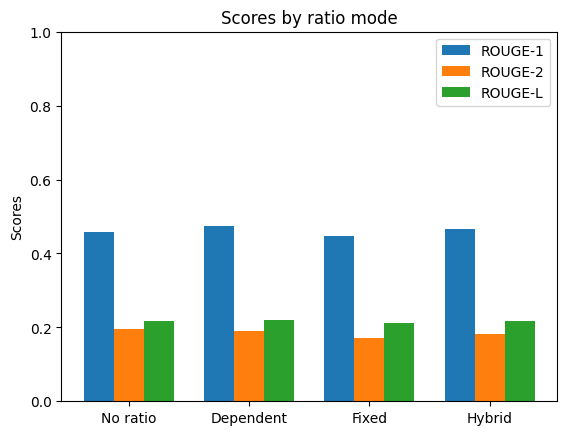

In [5]:
#Plot the Rouge metrics using matplotlib
rouge_1 = ratio_data['ROUGE-1'].values
rouge_2 = ratio_data['ROUGE-2'].values
rouge_l = ratio_data['ROUGE-L'].values


figure, ax = plt.subplots()
bar_labels = ratio_data.index
bar_labels = [x.capitalize() for x in bar_labels]

ratio_data_dict = {
    bar_labels[0]: rouge_1,
    bar_labels[1]: rouge_2,
    bar_labels[2]: rouge_l
}

bar_colors = ['r', 'g', 'b']

x = np.arange(len(bar_labels))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0


for attribute, measurement in ratio_data_dict.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    multiplier += 1

ax.set_ylabel('Scores')
ax.set_title('Scores by ratio mode')
ax.set_xticks(x + width, bar_labels)
ax.legend(['ROUGE-1', 'ROUGE-2', 'ROUGE-L'])
ax.set_ylim(0, 1)

plt.show()


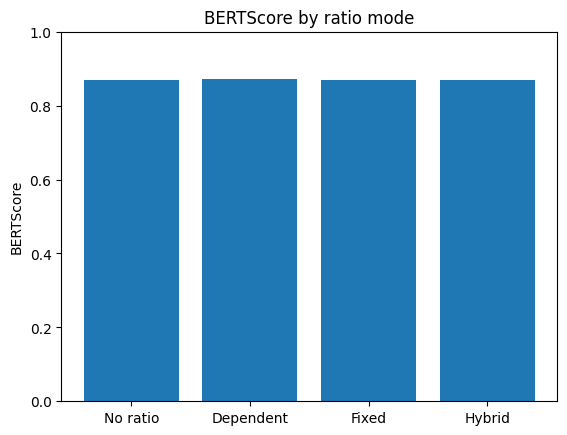

In [6]:
bert_score = ratio_data['BERTScore'].values

figure, ax = plt.subplots()
bar_labels = ratio_data.index
bar_labels = [x.capitalize() for x in bar_labels]

bar_colors = ['r', 'g', 'b']

x = np.arange(len(bar_labels))  # the label locations


rects = ax.bar(x, bert_score, label='BERTScore')

ax.set_ylabel('BERTScore')
ax.set_title('BERTScore by ratio mode')
ax.set_xticks(x, bar_labels)
ax.set_ylim(0, 1)

plt.show()


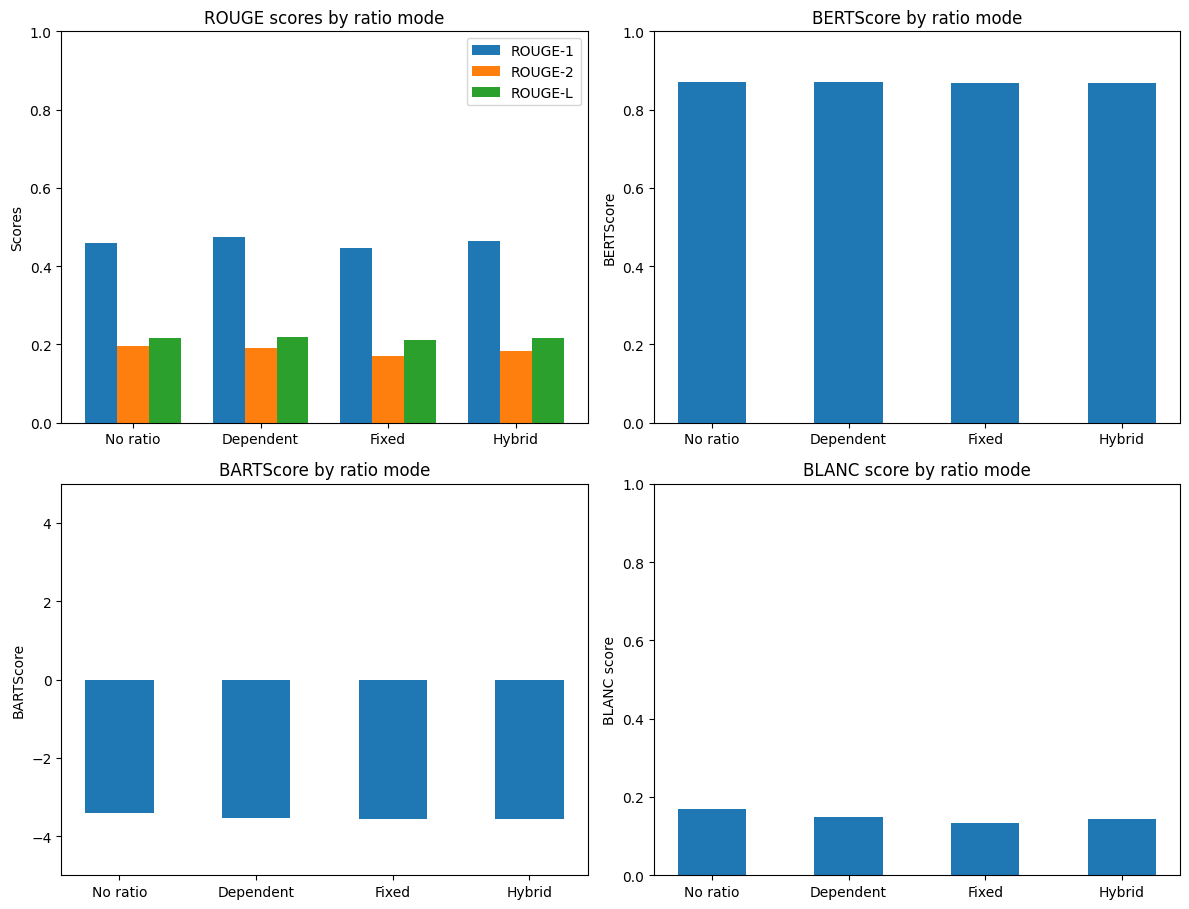

In [7]:
create_one_big_plot(ratio_data, 'ratio mode')

## 3.2: Legal vs Non Legal LMs (extractive)

### 3.2.1: Further process dataset and print latex

In [8]:
#Average results for models that are Legal and Non legal, resulting in two lists with results of the two groups

legal_data = extractive_research_data.groupby(['Legal_model']).mean()
legal_data = legal_data.drop(columns=['Context_length_extractive', 'Context_length_abstractive'])

# Create a copy of legal_data with the index renamed
legal_data_copy = legal_data.rename_axis('Model type').reset_index()


# Convert the modified DataFrame to LaTeX
caption = 'Average evaluation results for Legal LMs and General LMs'
print(create_latex_string(legal_data_copy, caption))

\begin{table}[h]
\centering
\begin{tabular}{lcccccc}
\toprule
Model type &  ROUGE-1 &  ROUGE-2 &  ROUGE-L &  BERTScore &  BARTScore &  BLANC \\
\midrule
General LM &   0.4681 &   0.1862 &   0.2180 &     0.8702 &    -3.5516 & 0.1469 \\
  Legal LM &   0.4568 &   0.1793 &   0.2150 &     0.8688 &    -3.5586 & 0.1413 \\
\bottomrule
\end{tabular}
\caption{Average evaluation results for Legal LMs and General LMs}
\label{tab: Average evaluation results for Legal LMs and General LMs}
\end{table}



/var/folders/d4/csgbs8kx47vg354l4c66hmvh0000gn/T/ipykernel_36128/2187269539.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  legal_data = extractive_research_data.groupby(['Legal_model']).mean()
/var/folders/d4/csgbs8kx47vg354l4c66hmvh0000gn/T/ipykernel_36128/3986773675.py:93: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_string = data.to_latex(index=False, float_format='%.4f', column_format= column_format, position='h')


### 3.2.2: Create graphs

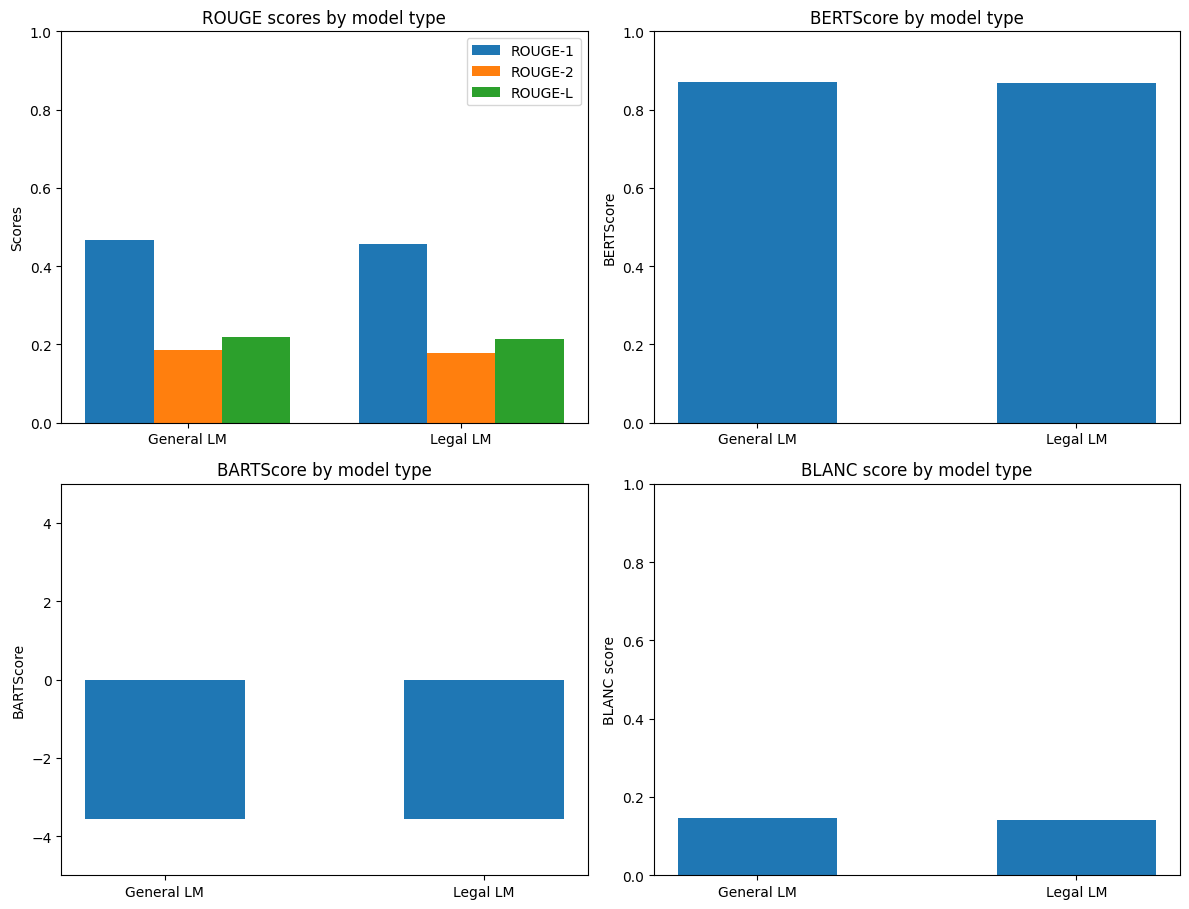

In [9]:
create_one_big_plot(legal_data, 'model type')

## 3.3: Long vs regular context length extractive LMs 

### 3.3.1: Further process dataset and print latex

In [10]:
#Average results for models that have the same context length

extractive_context_length_data = extractive_research_data.groupby(['Context_length_extractive']).mean()
extractive_context_length_data = extractive_context_length_data.drop(columns= ['Context_length_abstractive'])

# Create a copy of extractive_context_length_data with the index renamed
extractive_context_length_data_copy = extractive_context_length_data.rename_axis('Extractive context length').reset_index()


# Convert the modified DataFrame to LaTeX
caption = 'Average evaluation results for models with the same extractive context length'
print(create_latex_string(extractive_context_length_data_copy, caption))

\begin{table}[h]
\centering
\begin{tabular}{lcccccc}
\toprule
 Extractive context length &  ROUGE-1 &  ROUGE-2 &  ROUGE-L &  BERTScore &  BARTScore &  BLANC \\
\midrule
                  512.0000 &   0.4649 &   0.1838 &   0.2174 &     0.8696 &    -3.5554 & 0.1442 \\
                 4096.0000 &   0.4575 &   0.1780 &   0.2145 &     0.8690 &    -3.5792 & 0.1388 \\
\bottomrule
\end{tabular}
\caption{Average evaluation results for models with the same extractive context length}
\label{tab: Average evaluation results for models with the same extractive context length}
\end{table}



/var/folders/d4/csgbs8kx47vg354l4c66hmvh0000gn/T/ipykernel_36128/4152700239.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  extractive_context_length_data = extractive_research_data.groupby(['Context_length_extractive']).mean()
/var/folders/d4/csgbs8kx47vg354l4c66hmvh0000gn/T/ipykernel_36128/3986773675.py:93: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_string = data.to_latex(index=False, float_format='%.4f', column_format= column_format, position='h')


### 3.3.2: Create graphs

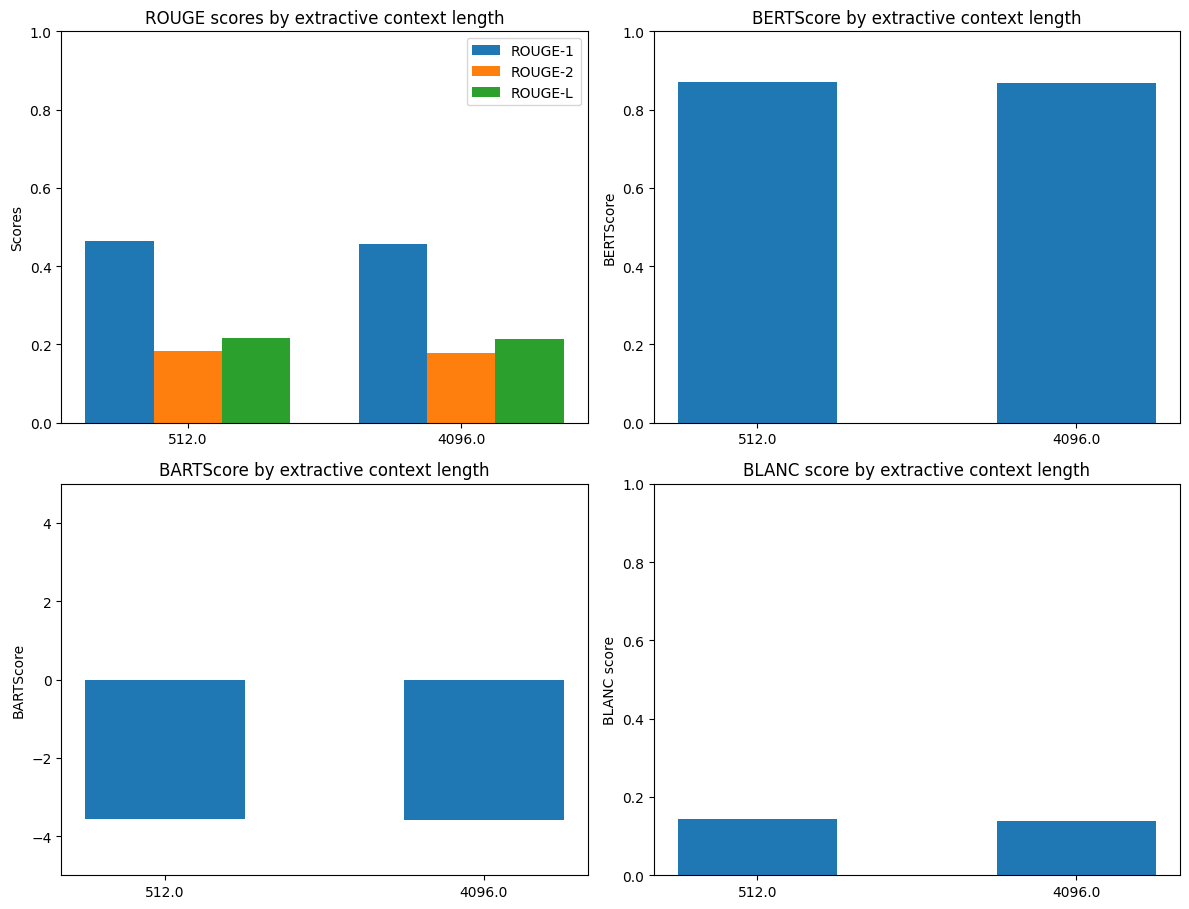

In [11]:
create_one_big_plot(extractive_context_length_data, 'extractive context length')

In [12]:
print(data.columns)

Index(['Model_ID', 'Extractive_model', 'Abstractive_model', 'Ratio_mode',
       'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'BERTScore', 'BARTScore', 'BLANC',
       'Legal_model', 'Context_length_extractive',
       'Context_length_abstractive'],
      dtype='object')


## 3.4: Long vs regular context length abstractive LMs 

### 3.4.1: Further process dataset and print latex

### 3.4.2: Create graphs

## Top 5 ranking of extractive models

In [13]:

# Create a dictionary to store the top 5 models for each metric
top_5_models = {metric: [] for metric in extractive_research_data.columns[4:10]}
for metric in top_5_models:
    top_5_models[metric] = extractive_research_data.nlargest(5, metric)['Model_ID'].values

# Print the top 5 models for each metric
for metric, models in top_5_models.items():
    print(f'Top 5 models for {metric}: {models}')

Top 5 models for ROUGE-1: ['RoBERTa_BART_dependent_V1' 'LexLM_BART_dependent_V1'
 'RoBERTa_BART_hybrid_V1' 'Longformer_BART_hybrid_V1'
 'LexLM_Longformer_BART_dependent_V1']
Top 5 models for ROUGE-2: ['RoBERTa_BART_dependent_V1' 'LexLM_BART_dependent_V1'
 'BART_no_extraction_V2' 'RoBERTa_BART_hybrid_V1'
 'Longformer_BART_dependent_V1']
Top 5 models for ROUGE-L: ['RoBERTa_BART_dependent_V1' 'LexLM_BART_dependent_V1'
 'Longformer_BART_dependent_V1' 'RoBERTa_BART_hybrid_V1'
 'LexLM_Longformer_BART_hybrid_V1']
Top 5 models for BERTScore: ['RoBERTa_BART_dependent_V1' 'LexLM_BART_dependent_V1'
 'LegalBERT_BART_dependent_V1' 'Longformer_BART_dependent_V1'
 'Longformer_BART_hybrid_V1']
Top 5 models for BARTScore: ['BART_no_extraction_V2' 'LegalBERT_BART_fixed_V1'
 'LegalBERT_BART_dependent_V1' 'LexLM_Longformer_BART_dependent_V1'
 'LexLM_BART_dependent_V1']
Top 5 models for BLANC: ['BART_no_extraction_V2' 'LexLM_BART_dependent_V1'
 'RoBERTa_BART_dependent_V1' 'Longformer_BART_dependent_V1'
 'R

In [14]:
extractive_research_data_copy = extractive_research_data.sort_values(by= 'Extractive_model')
extractive_research_data_copy = extractive_research_data_copy.drop(columns=['Context_length_extractive', 'Context_length_abstractive', 'Model_ID', 'Abstractive_model', 'Legal_model'])
extractive_research_data_copy = extractive_research_data_copy[['Extractive_model', 'Ratio_mode', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'BERTScore', 'BARTScore', 'BLANC']]
extractive_research_data_copy.rename(columns={'Extractive_model': 'Extractive model', 'Ratio_mode': 'Ratio type'}, inplace=True)

extractive_research_data_copy['Ratio type'] = extractive_research_data_copy['Ratio type'].replace('No ratio', 'No extraction')
extractive_research_data_copy['Ratio type'] = extractive_research_data_copy['Ratio type'].replace('dependent', 'Dependent ')
extractive_research_data_copy['Ratio type'] = extractive_research_data_copy['Ratio type'].replace('fixed', 'Fixed ')
extractive_research_data_copy['Ratio type'] = extractive_research_data_copy['Ratio type'].replace('hybrid', 'Hybrid ')

caption = "Evaluation results of all extractive models with all ratio types, fine-tuned on BART. When no extractive model is used, this is showcased with ’-’."
print(create_latex_string(extractive_research_data_copy, caption))

\begin{table}[h]
\centering
\begin{tabular}{lccccccc}
\toprule
   Extractive model &    Ratio type &  ROUGE-1 &  ROUGE-2 &  ROUGE-L &  BERTScore &  BARTScore &  BLANC \\
\midrule
          LegalBERT &    Dependent  &   0.4619 &   0.1854 &   0.2174 &     0.8713 &    -3.5143 & 0.1463 \\
          LegalBERT &        Fixed  &   0.4390 &   0.1766 &   0.2158 &     0.8700 &    -3.4893 & 0.1427 \\
          LegalBERT &       Hybrid  &   0.4469 &   0.1774 &   0.2137 &     0.8665 &    -3.5714 & 0.1423 \\
              LexLM &        Fixed  &   0.4571 &   0.1745 &   0.2123 &     0.8692 &    -3.6130 & 0.1350 \\
              LexLM &    Dependent  &   0.4859 &   0.1954 &   0.2227 &     0.8713 &    -3.5441 & 0.1543 \\
              LexLM &       Hybrid  &   0.4582 &   0.1792 &   0.2135 &     0.8665 &    -3.5639 & 0.1421 \\
   LexLM\_Longformer &        Fixed  &   0.4250 &   0.1584 &   0.2041 &     0.8659 &    -3.6141 & 0.1258 \\
   LexLM\_Longformer &    Dependent  &   0.4751 &   0.1852 &   0.2164 &

/var/folders/d4/csgbs8kx47vg354l4c66hmvh0000gn/T/ipykernel_36128/3986773675.py:93: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_string = data.to_latex(index=False, float_format='%.4f', column_format= column_format, position='h')


### Appending RoBERTa_BART_dependent_V1 to abstractive dataset as it's the best performing

In [15]:
best_performing_model = extractive_research_data[extractive_research_data['Model_ID'] == 'RoBERTa_BART_dependent_V1']
abstractive_research_data= abstractive_research_data.append(best_performing_model)

/var/folders/d4/csgbs8kx47vg354l4c66hmvh0000gn/T/ipykernel_36128/1576231356.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  abstractive_research_data= abstractive_research_data.append(best_performing_model)


# Part 4: Data analysis of abstractive models


In [16]:
# Create a dictionary to store the top 5 models for each metric
#TODO: Remove 
top_5_models = {metric: [] for metric in abstractive_research_data.columns[4:10]}
for metric in top_5_models:
    top_5_models[metric] = abstractive_research_data.nlargest(5, metric)['Model_ID'].values

# Print the top 5 models for each metric
for metric, models in top_5_models.items():
    print(f'Top 5 models for {metric}: {models}')

Top 5 models for ROUGE-1: ['RoBERTa_BART_dependent_V1' 'BART_no_extraction_V2'
 'RoBERTa_Llama3_dependent_V2' 'Llama3_no_extraction_V2'
 'PegasusX_no_extraction_V1']
Top 5 models for ROUGE-2: ['RoBERTa_BART_dependent_V1' 'BART_no_extraction_V2'
 'RoBERTa_Llama3_dependent_V2' 'Llama3_no_extraction_V2'
 'PegasusX_no_extraction_V1']
Top 5 models for ROUGE-L: ['PegasusX_no_extraction_V1' 'RoBERTa_Llama3_dependent_V2'
 'Pegasus_no_extraction_V1' 'RoBERTa_BART_dependent_V1'
 'LongT5_no_extraction_V1']
Top 5 models for BERTScore: ['RoBERTa_BART_dependent_V1' 'BART_no_extraction_V2'
 'RoBERTa_Llama3_dependent_V2' 'PegasusX_no_extraction_V1'
 'Pegasus_no_extraction_V1']
Top 5 models for BARTScore: ['Pegasus_no_extraction_V1' 'RoBERTa_Pegasus_dependent_V1'
 'RoBERTa_LongT5_dependent_V1' 'T5_no_extraction_V1'
 'LongT5_no_extraction_V1']
Top 5 models for BLANC: ['LongT5_no_extraction_V1' 'BART_no_extraction_V2'
 'PegasusX_no_extraction_V1' 'Pegasus_no_extraction_V1'
 'RoBERTa_Llama3_dependent_V2']

## 4.1: Effect of extractive step

In [17]:
print(abstractive_research_data)

                         Model_ID     Extractive_model Abstractive_model  \
0             T5_no_extraction_V1  No extractive model                T5   
1        Pegasus_no_extraction_V1  No extractive model           Pegasus   
2       PegasusX_no_extraction_V1  No extractive model          PegasusX   
3   RoBERTa_PegasusX_dependent_V1              RoBERTa          PegasusX   
4         RoBERTa_T5_dependent_V1              RoBERTa                T5   
5    RoBERTa_Pegasus_dependent_V1              RoBERTa           Pegasus   
6         LongT5_no_extraction_V1  No extractive model            LongT5   
7     RoBERTa_LongT5_dependent_V1              RoBERTa            LongT5   
8         Llama3_no_extraction_V2  No extractive model            Llama3   
9     RoBERTa_Llama3_dependent_V2              RoBERTa            Llama3   
10          BART_no_extraction_V2  No extractive model              BART   
3       RoBERTa_BART_dependent_V1              RoBERTa              BART   

   Ratio_mo

In [18]:
abstractive_research_data_copy = abstractive_research_data.sort_values(by= 'Abstractive_model')
abstractive_research_data_copy = abstractive_research_data_copy.drop(columns=['Context_length_extractive', 'Model_ID', 'Extractive_model', 'Legal_model'])
abstractive_research_data_copy = abstractive_research_data_copy[['Abstractive_model', 'Ratio_mode', 'Context_length_abstractive', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'BERTScore', 'BARTScore', 'BLANC']]
abstractive_research_data_copy.rename(columns={'Abstractive_model': 'Abstractive model', 'Ratio_mode': 'Ratio type', 'Context_length_abstractive': 'Context length'}, inplace=True)

abstractive_research_data_copy['Ratio type'] = abstractive_research_data_copy['Ratio type'].replace('No ratio', 'No extraction')
abstractive_research_data_copy['Ratio type'] = abstractive_research_data_copy['Ratio type'].replace('dependent', 'Dependent ')

caption = 'Evaluation results of all abstractive models with and without an extractive step'
print(create_latex_string(abstractive_research_data_copy, caption))

\begin{table}[h]
\centering
\begin{tabular}{lcccccccc}
\toprule
Abstractive model &    Ratio type &  Context length &  ROUGE-1 &  ROUGE-2 &  ROUGE-L &  BERTScore &  BARTScore &  BLANC \\
\midrule
             BART & No extraction &            1024 &   0.4590 &   0.1954 &   0.2174 &     0.8702 &    -3.4154 & 0.1700 \\
             BART &    Dependent  &            1024 &   0.4873 &   0.1974 &   0.2247 &     0.8721 &    -3.5590 & 0.1541 \\
           Llama3 & No extraction &            8192 &   0.4088 &   0.1816 &   0.2107 &     0.7854 &    -3.3424 & 0.1545 \\
           Llama3 &    Dependent  &            8192 &   0.4474 &   0.1885 &   0.2284 &     0.8687 &    -3.1268 & 0.1563 \\
           LongT5 & No extraction &           16384 &   0.3261 &   0.1309 &   0.2192 &     0.8497 &    -2.2195 & 0.1745 \\
           LongT5 &    Dependent  &           16384 &   0.2854 &   0.0969 &   0.0969 &     0.8444 &    -2.0423 & 0.1493 \\
          Pegasus & No extraction &            1024 &   0.3305 &  

/var/folders/d4/csgbs8kx47vg354l4c66hmvh0000gn/T/ipykernel_36128/3986773675.py:93: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_string = data.to_latex(index=False, float_format='%.4f', column_format= column_format, position='h')


## 4.2: Repetition analysis

In [20]:
import re
import os

# Function to detect heavy repetition in a summary and return repeated sentences
def detect_heavy_repetition(text, threshold=5):
    sentences = text.split('.')
    sentence_counts = {}
    
    for sentence in sentences:
        sentence = sentence.strip()
        if sentence in sentence_counts:
            sentence_counts[sentence] += 1
        else:
            sentence_counts[sentence] = 1

    repeated_sentences = [sentence for sentence, count in sentence_counts.items() if count >= threshold and len(sentence) >= 10]
    
    return repeated_sentences if repeated_sentences else None

# List of text files by model type and variant
model_files = {
    "BART": [
        "RoBERTa_BART_dependent_V1_predictions.txt",
        "BART_no_extraction_V2_predictions.txt"
    ],
    "T5": [
        "T5_no_extraction_V1_predictions.txt",
        "RoBERTa_T5_dependent_V1_predictions.txt"
    ],
    "LongT5": [
        "LongT5_no_extraction_V1_predictions.txt",
        "RoBERTa_LongT5_dependent_V1_predictions.txt"
    ],
    "Pegasus": [
        "Pegasus_no_extraction_V1_predictions.txt",
        "RoBERTa_Pegasus_dependent_V1_predictions.txt"
    ],
    "PegasusX": [
        "PegasusX_no_extraction_V1_predictions.txt",
        "RoBeRTa_PegasusX_dependent_V1_predictions.txt"
    ],
    "Llama3": [
        "Llama3_no_extraction_V2_predictions.txt",
        "RoBERTa_Llama3_dependent_V2_predictions.txt"
    ],
    "Baseline": [
        "actual_summaries.txt",
    ]
}

# Initialize dictionaries to store results
model_variant_counts = {model: [] for model in model_files}
model_averages = {}

# Process each model and its variants
with open("text_outputs/repetition_analysis_results.txt", 'w') as output_file:
    for model, files in model_files.items():
        model_total_summaries = 0
        model_total_heavy_repetition = 0

        for file_idx, file_path in enumerate(files):
            file_path = os.path.join('text_outputs', file_path)
            with open(file_path, 'r', encoding='utf-8') as file:
                content = file.read()

            # Split content into individual summaries
            summaries = re.split(r'Summary \d+:', content)[1:]  # Skip the header part

            # Detect heavy repetition in each summary
            heavy_repetition_count = 0
            output_file.write(f"Model: {model} Variant: {files[file_idx]}\n")
            for idx, summary in enumerate(summaries):
                repeated_sentences = detect_heavy_repetition(summary)
                if repeated_sentences:
                    heavy_repetition_count += 1

            model_variant_counts[model].append(heavy_repetition_count)
            model_total_summaries += len(summaries)
            model_total_heavy_repetition += heavy_repetition_count

            output_file.write(f"  Total heavy repetition cases: {heavy_repetition_count}\n")

            for idx, summary in enumerate(summaries):
                repeated_sentences = detect_heavy_repetition(summary)
                if repeated_sentences:
                    output_file.write(f"    Summary {idx}: {repeated_sentences}\n")

        model_averages[model] = model_total_heavy_repetition / len(files)

    # Print results
    for model, counts in model_variant_counts.items():
        print(f"Model: {model}")
        output_file.write(f"Model: {model}\n")
        for i, count in enumerate(counts):
            print(f"  Variant {i + 1}: {count} heavy repetition cases")
            output_file.write(f"  Variant {i + 1}: {count} heavy repetition cases\n")
        print(f"  Average: {model_averages[model]}")
        output_file.write(f"  Average: {model_averages[model]}\n")

print("Analysis results saved to text_outputs/repetition_analysis_results.txt")

Model: BART
  Variant 1: 0 heavy repetition cases
  Variant 2: 0 heavy repetition cases
  Average: 0.0
Model: T5
  Variant 1: 73 heavy repetition cases
  Variant 2: 108 heavy repetition cases
  Average: 90.5
Model: LongT5
  Variant 1: 163 heavy repetition cases
  Variant 2: 160 heavy repetition cases
  Average: 161.5
Model: Pegasus
  Variant 1: 143 heavy repetition cases
  Variant 2: 150 heavy repetition cases
  Average: 146.5
Model: PegasusX
  Variant 1: 103 heavy repetition cases
  Variant 2: 114 heavy repetition cases
  Average: 108.5
Model: Llama3
  Variant 1: 29 heavy repetition cases
  Variant 2: 24 heavy repetition cases
  Average: 26.5
Model: Baseline
  Variant 1: 4 heavy repetition cases
  Average: 4.0
Analysis results saved to text_outputs/repetition_analysis_results.txt
